##### Import modules and set up file locations

In [1]:
full_run = False

In [2]:
from Comparative_Analysis import Sequence_Analysis_Routines as sar
from Comparative_Analysis import HMM as hmm
from Comparative_Analysis import Utilities as util
from Comparative_Analysis import Alignment_HMM as alignment_hmm
from Comparative_Analysis import Alignment_Analysis as alignment_analysis
from Comparative_Analysis import Alignment as align
from Comparative_Analysis import Master_Alignment_HMM as master_alignment_hmm
import random
from joblib import Parallel, delayed
from scipy import optimize as opt
from tqdm import tqdm
import matplotlib.pyplot as plt
import logomaker as lm
import math
import pandas as pd
import subprocess
import numpy as np
import ete3;
import pickle

C:\Users\nicho\Anaconda3\envs\Projects\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\nicho\Anaconda3\envs\Projects\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [3]:
project_dir = 'D:/Project_Data/Project_3'
sonic_paranoid_run_name = 'Run_Without_Outgroup'
outgroup_sonic_paranoid_run_name = 'Run_With_Outgroup'
genome_datasets_dir = project_dir + '/Datasets/NCBI_Datasets_Close_Species/'
output_dir = project_dir + '/Output/Close_Species'
protein_fasta_output_loc = output_dir + '/Protein_Sequences'
outgroup_protein_fasta_output_loc = output_dir + '/Protein_Sequences_With_Outgroup'
sonic_paranoid_output_loc = output_dir + '/Sonic_Paranoid_Output'
ortholog_dir = sonic_paranoid_output_loc + '/runs/' + sonic_paranoid_run_name + '/ortholog_groups'
outgroup_ortholog_dir = sonic_paranoid_output_loc + '/runs/' + outgroup_sonic_paranoid_run_name + '/ortholog_groups'
non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Non_CDS'
upstream_non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Upstream_Non_CDS'
cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS'
extended_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Extended_CDS'
outgroup_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup'
outgroup_concatenated_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup_Concatenated'
hmm_parameters_output_dir = output_dir +'/HMM_Model_Parameters'
conservation_analysis_output_dir = output_dir + '/Conservation_Analysis_Output'

In [4]:
num_cores = 16
core_numbers = list(range(1, num_cores+1))
non_cds_offset = 50
extended_cds_offset = 100
tb_species = 'GCF_000195955.2'
outgroup_species = 'GCF_000696675.2'

##### Determine genomes in ortholog family, generate protein files and run Sonic Paranoid (both with and without outgroup - outgroup needed for tree building)

In [7]:
genome_ids_with_outgroup = util.list_dirs(genome_datasets_dir)
genome_ids = util.list_dirs(genome_datasets_dir)
genome_ids.remove(outgroup_species)
non_target_genome_ids = util.list_dirs(genome_datasets_dir)
non_target_genome_ids.remove(outgroup_species)
non_target_genome_ids.remove(tb_species)
num_ids = len(genome_ids)
num_ids_with_outgroup = len(genome_ids_with_outgroup)

In [8]:
if full_run == True:
    for folder in sar.tqdm(genome_ids):
        sar.generate_protein_file(genome_datasets_dir + '/' + folder + '/genomic.gbff', protein_fasta_output_loc + '/' + folder + '.faa')
    for folder in sar.tqdm(genome_ids_with_outgroup):
        sar.generate_protein_file(genome_datasets_dir + '/' + folder + '/genomic.gbff', outgroup_protein_fasta_output_loc + '/' + folder + '.faa')

In [9]:
if full_run == True:
    sar.run_sonic_paranoid(protein_fasta_output_loc, sonic_paranoid_output_loc, sonic_paranoid_run_name)
    sar.run_sonic_paranoid(outgroup_protein_fasta_output_loc, sonic_paranoid_output_loc, outgroup_sonic_paranoid_run_name)

##### Generate objects containing orthologs and sequence information for each ortholog group / species

In [10]:
orthologs = sar.Ortholog_Grouping(ortholog_dir)
outgroup_orthologs = sar.Ortholog_Grouping(outgroup_ortholog_dir)

100%|██████████| 84312/84312 [00:05<00:00, 15642.30it/s]


In [11]:
seq_data = sar.Ortholog_Sequence_Dataset(orthologs, genome_datasets_dir, genome_ids, non_cds_offset, tb_species) 
outgroup_seq_data = sar.Ortholog_Sequence_Dataset(outgroup_orthologs, genome_datasets_dir, genome_ids_with_outgroup, non_cds_offset, tb_species) 
all_copy_seq_data = sar.Ortholog_Sequence_Dataset(orthologs, genome_datasets_dir, genome_ids, non_cds_offset, tb_species, single_copy = False) 
#print(outgroup_seq_data.species_info())

100%|██████████| 16/16 [00:00<00:00, 16108.70it/s]


In [ ]:
#seq_data.generate_synteny_plot()
#seq_data.generate_ortholog_count_plot()
#all_copy_seq_data.generate_master_count_plot()
seq_data.generate_unassigned_gene_count_plot()

##### Perform CDS and non-CDS alignments for each full ortholog group and save to folders

In [ ]:
min_species = num_ids
min_species_with_outgroup = num_ids_with_outgroup
groups = random.sample(orthologs.full_single_copy_ortholog_groups, len(orthologs.full_single_copy_ortholog_groups))  #Permutation ensures even distribution of processing speeds
outgroup_groups = random.sample(outgroup_orthologs.full_single_copy_ortholog_groups, len(outgroup_orthologs.full_single_copy_ortholog_groups))  #Permutation ensures even distribution of processing speeds
if full_run == True:
    par = Parallel(n_jobs=-1)(delayed(align.align_and_build)(outgroup_groups, num_cores, core_number, outgroup_seq_data.sequence_data, 'cds_length', 'cds_seq', outgroup_cds_output_dir+'/', min_species_with_outgroup) for core_number in tqdm(core_numbers))
    par = Parallel(n_jobs=-1)(delayed(align.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'cds_length', 'cds_seq', cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))
    par = Parallel(n_jobs=-1)(delayed(align.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'non_cds_offset_length', 'non_cds_offset_seq', non_cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))
    par = Parallel(n_jobs=-1)(delayed(align.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'upstream_non_cds_offset_length', 'upstream_non_cds_offset_seq', upstream_non_cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))
    par = Parallel(n_jobs=-1)(delayed(align.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'cds_extended_region_length', 'cds_extended_region_seq', extended_cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))

##### Run IQTree on concatenated CDS alignments to generate tree and rename with full names

In [ ]:
if full_run == True:
    alignment_names = util.list_files(outgroup_cds_output_dir)
    util.concatenate_fasta(outgroup_cds_output_dir, alignment_names, outgroup_concatenated_cds_output_dir + '/concatenated_cds.fasta')
    subprocess.run('cd \\users\\nicho\\IQTree & bin\\iqtree2 -s ' + outgroup_concatenated_cds_output_dir + '/concatenated_cds.fasta' + ' --prefix '+ output_dir + 
                   '/Trees/Concatenated_JC_Tree -m JC -B 1000 -T AUTO -o ' + outgroup_species, shell=True)

In [ ]:
if full_run == True:
    master_tree = ete3.Tree(output_dir + '/Trees/Concatenated_JC_Tree.treefile')
    for node in master_tree.traverse():
        if node.is_leaf():
            node.name = outgroup_seq_data.organism_dict[node.name] 
    master_tree.write(format=0, outfile= output_dir + '/Trees/Concatenated_JC_Tree_Full_Names.treefile')    

##### Fit overall Alignment and Pairwise HMMs using EM

In [ ]:
num_symbols = 4
num_states = 3
minimum_fit_length = 10
initial_params = [0.95, 0.5, 0.95, 0.5, 0.95, 0.5, 0.56370018, 0.52131172, 0.33906948]

In [ ]:
Alignment_HMM_Model = alignment_hmm.Alignment_HMM (num_symbols, num_states, non_cds_output_dir, tb_species)
if full_run == True:
    parameter_fits = Alignment_HMM_Model.EM_update(num_cores, initial_params, non_cds_offset, minimum_fit_length)
    fitted_parameters = parameter_fits[3]
    with open(hmm_parameters_output_dir + '/' + 'full_parameter_fit.pkl', 'wb') as f:
        pickle.dump(fitted_parameters, f)

In [ ]:
if full_run == True:
    parameter_fits = []
    for id in non_target_genome_ids:
        parameter_fits.append((id, Alignment_HMM_Model.EM_update(num_cores, initial_params, non_cds_offset, minimum_fit_length, all_species = False, comparison_species = id)[3]))
    with open(hmm_parameters_output_dir + '/' + 'pairwise_parameter_fits.pkl', 'wb') as f:
        pickle.dump(parameter_fits, f)

In [ ]:
#  Max likelihood using general optimisation - slower than EM
#bound_tuple = [(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999),(0.001,0.999)]
#def parallel_alignment_hmm_log_likelihood (params):
#    core_numbers = range(1, num_cores+1)
#    a = Parallel(n_jobs=-1)(delayed(Alignment_HMM_Model.alignment_hmm_log_likelihood)(params, num_cores, core_number, non_cds_offset, minimum_fit_length) for core_number in core_numbers)
#    print(params, sum(a))
#    return sum(a)  
#    res = opt.minimize(parallel_alignment_hmm_log_likelihood, params, method = 'Nelder-Mead', bounds = bound_tuple)

##### Fit overall HMM to pairwise HMMs

In [ ]:
def parallel_generate_pairwise_state_probabilities(num_subsets, subset_num, ids, num_states, pairwise_fitted_parameters):
    ids = util.chunk_list(ids, num_subsets, subset_num)
    pairwise_observation_probabilities = []
    for group_id in ids:
        temp = []
        alignment = align.Alignment(non_cds_output_dir +'/'+str(group_id)+'.fasta', tb_species, 'NT')
        alignment.modify_sequence(1,False,False)
        for params in pairwise_fitted_parameters:
                transition_probabilities, mutation_probabilities = Alignment_HMM_Model.alignment_hmm_model_inputs(params[1])
                observation_probabilities = Alignment_HMM_Model.calculate_observation_probs(mutation_probabilities, alignment.modified_sequence_list, alignment, all_species=False, comparison_species = params[0])
                initial_state_probabilities = [1.0/num_states]*num_states
                hmm_model = hmm.HMM(initial_state_probabilities, transition_probabilities, observation_probabilities)
                hmm_model.calculate_probabilities()
                temp.append(hmm_model.state_probabilities)
        pairwise_observation_probabilities.append(temp) 
    return pairwise_observation_probabilities

In [ ]:
with open(hmm_parameters_output_dir + '/' + 'pairwise_parameter_fits.pkl', 'rb') as f:
    pairwise_fitted_parameters = pickle.load(f)
file_ids = util.list_files(non_cds_output_dir + '/')
ids = [int(i.split('.')[0]) for i in file_ids] 
parallel_output = Parallel(n_jobs=-1)(delayed(parallel_generate_pairwise_state_probabilities)(num_cores, core_number, ids, num_states, pairwise_fitted_parameters) for core_number in core_numbers)
pairwise_observation_probabilities = [item for sublist in parallel_output for item in sublist]

In [ ]:
Master_Alignment_HMM_Model = master_alignment_hmm.Master_Alignment_HMM (pairwise_observation_probabilities)
initial_params = [0.8, 0.5, 0.9, 0.3]
if full_run == True:
    parameter_fits = Master_Alignment_HMM_Model.EM_update(num_cores, initial_params, non_cds_offset, minimum_fit_length)
    fitted_parameters = parameter_fits[3]
    print(fitted_parameters)
    with open(hmm_parameters_output_dir + '/' + 'master_parameter_fit.pkl', 'wb') as f:
        pickle.dump(fitted_parameters, f)

##### Load HMM parameters

In [ ]:
with open(hmm_parameters_output_dir + '/' + 'full_parameter_fit.pkl', 'rb') as f:
    full_fitted_parameters = pickle.load(f)
with open(hmm_parameters_output_dir + '/' + 'pairwise_parameter_fits.pkl', 'rb') as f:
    pairwise_fitted_parameters = pickle.load(f)
with open(hmm_parameters_output_dir + '/' + 'master_parameter_fit.pkl', 'rb') as f:
    master_fitted_parameters = pickle.load(f)

In [ ]:
for params in pairwise_fitted_parameters:
    transition_probabilities, mutation_probabilities = Alignment_HMM_Model.alignment_hmm_model_inputs(params[1])
    #print(seq_data.organism_dict[params[0]],transition_probabilities, mutation_probabilities)

transition_probabilities, mutation_probabilities = Master_Alignment_HMM_Model.alignment_hmm_model_inputs(master_fitted_parameters)
print(transition_probabilities, mutation_probabilities)

##### Analyse ortholog groups for conservation and other features and output to dictionary

In [ ]:
def parallel_build_analysis_dictionary(num_subsets, subset_num, ids, analysis_type):
    ids = util.chunk_list(ids, num_subsets, subset_num)
    output_list = []
    for group_id in ids:
        alignment = align.Alignment(alignment_dir+'/'+str(group_id)+'.fasta', tb_species, 'NT')
        analysis = alignment_analysis.Alignment_Analysis(analysis_type, alignment, num_states, non_cds_offset, group_id, full_fitted_parameters, project_dir, Alignment_HMM_Model, 
                                                         Master_Alignment_HMM_Model, pairwise_fitted_parameters, master_fitted_parameters, seq_data)
        output_list.append((group_id, analysis))
    return output_list

In [ ]:
if full_run == True:
    for analysis_type in ['Downstream', 'Upstream']:
        if analysis_type == 'Downstream':
            alignment_dir = non_cds_output_dir
            dict_name = 'downstream_conservation_info_dictionary'
        else:
            alignment_dir = upstream_non_cds_output_dir
            dict_name = 'upstream_conservation_info_dictionary'
        alignment_info_dict = {}
        file_ids = util.list_files(alignment_dir+'/')
        ids = [int(i.split('.')[0]) for i in file_ids]
        parallel_output = Parallel(n_jobs=-1)(delayed(parallel_build_analysis_dictionary)(num_cores, core_number, ids, analysis_type) for core_number in tqdm(core_numbers))
        dictionary_list = [item for sublist in parallel_output for item in sublist]
        alignment_info_dict = {}
        for (group, analysis) in dictionary_list:
            alignment_info_dict[group] = analysis
        with open(conservation_analysis_output_dir + '/' + dict_name + '.pkl', 'wb') as f:
            pickle.dump(alignment_info_dict, f)

In [5]:
with open(conservation_analysis_output_dir + '/upstream_conservation_info_dictionary.pkl', 'rb') as f:
    upstream_conservation_info_dictionary = pickle.load(f)
with open(conservation_analysis_output_dir + '/downstream_conservation_info_dictionary.pkl', 'rb') as f:
    downstream_conservation_info_dictionary = pickle.load(f)

##### Plot graphics to show sequence and HMM regions

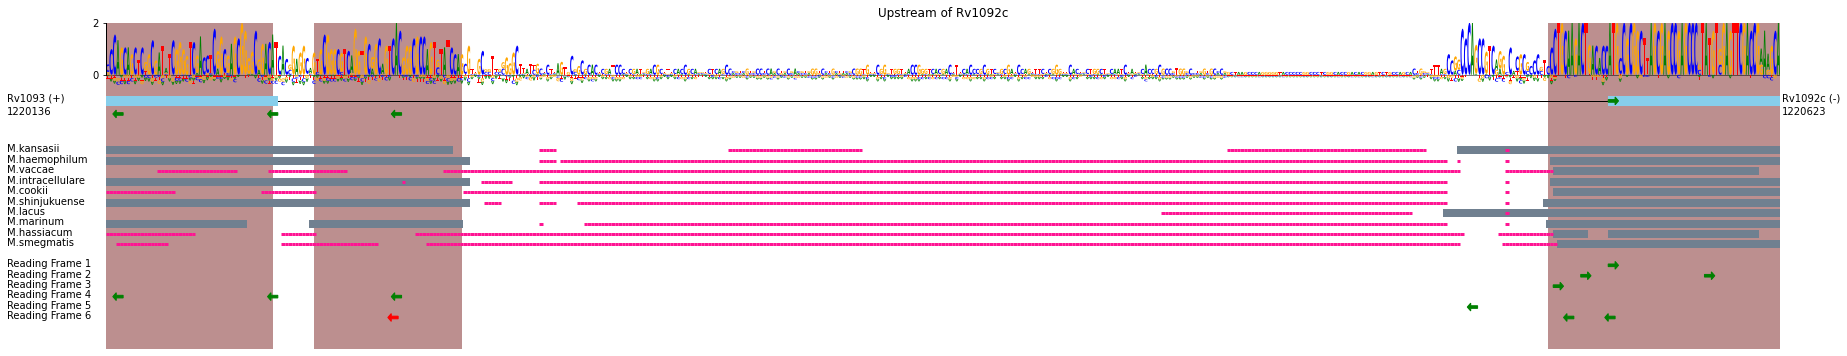

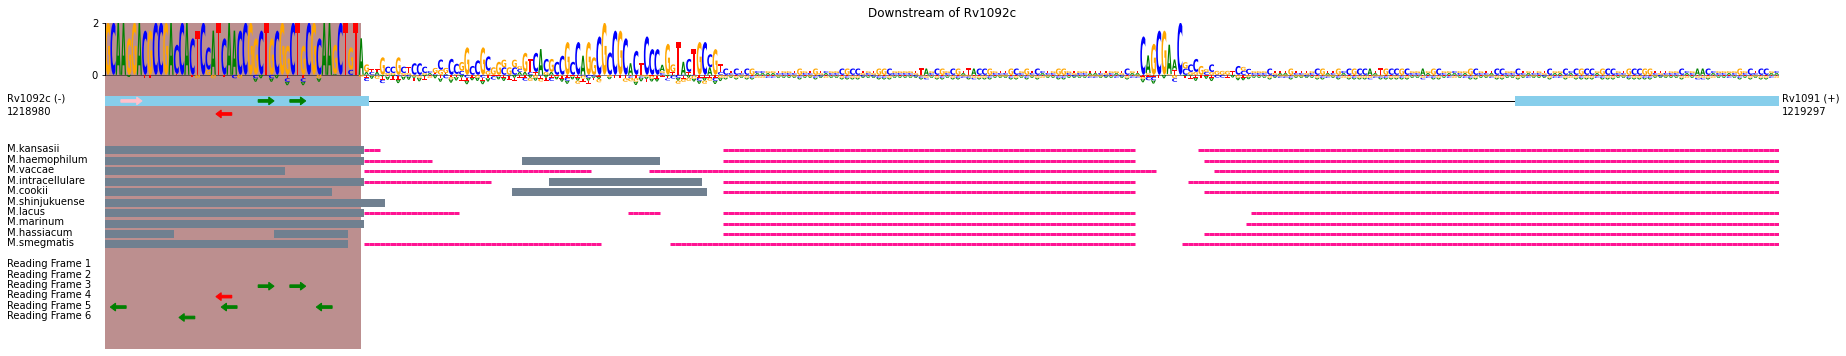

In [42]:
group_id = 839 #1161 #1337 1007 839    #use 1120 in slides!  Also 1115 is interesting to discuss    #1116 is interesting 
     #1120 can see the labels work!
    #1161 817 758 1337 1114 List of sRNA in Arnvig 2011          Rv2976a intervenes on third one
    #2131 not very well conserved in Arnvig 2011
    #1129
    #1169 shows upstream start in DeJesus
    #1214 massive!
    #1009 not much conservation
    # 993 definitely looks like an upstream start site for reverse strand??
upstream_conservation_info_dictionary[group_id].display_analysis()
downstream_conservation_info_dictionary[group_id].display_analysis()

In [ ]:
data = upstream_conservation_info_dictionary[group_id]
#plt.plot(data.alignment.relative_entropy);
#plt.plot(data.alignment.mvave_relative_entropy);
plt.axvline(x=data.buffer_end, ymin=0, ymax=2, color='r');
plt.axvline(x=data.target_end, ymin=0, ymax=2, color='r');
for state in [0]:
    plt.plot(data.hmm_model.viterbi_path);

In [41]:
temp= seq_data.sequence_data
group_id = (temp[temp['locus_tag'] == 'Rv1092c'].iloc[0]['group_id'])
temp[temp['group_id'] == group_id]

,group_id,species,protein_id,num_protein_ids,name,type,locus_tag,previous_locus_tag,next_locus_tag,bp_restrict,...,non_cds_length,upstream_non_cds_length,cds_extended_region_length,ss_non_cds_length,non_cds_offset_length,non_cds_offset_start,non_cds_offset_end,upstream_non_cds_offset_length,upstream_non_cds_offset_start,upstream_non_cds_offset_end
646,839,GCF_000157895.3,WP_023366919.1,1.0,Mycobacterium kansasii ATCC 12478,CDS,MKAN_RS07680,MKAN_RS07675,MKAN_RS07685,1.0,...,27.0,311.0,1277.0,5355.0,127.0,1818908.0,1819035.0,411.0,1817658.0,1818069.0
683,839,GCF_000195955.2,NP_215608.1,1.0,Mycobacterium tuberculosis H37Rv,CDS,Rv1092c,Rv1091,Rv1093,1.0,...,217.0,387.0,1543.0,8763.0,317.0,1218980.0,1219297.0,487.0,1220136.0,1220623.0
672,839,GCF_000340435.2,WP_047316038.1,1.0,Mycobacterium haemophilum DSM 44634,CDS,B586_RS15230,B586_RS15225,B586_RS15235,1.0,...,17.0,137.0,1093.0,2821.0,117.0,3265137.0,3265254.0,237.0,3264061.0,3264298.0
645,839,GCF_001655245.1,WP_003930065.1,1.0,Mycolicibacterium vaccae 95051,CDS,MYVA_RS21850,MYVA_RS21845,MYVA_RS21855,1.0,...,0.0,31.0,970.0,4355.0,71.0,4688998.0,4689069.0,131.0,4688028.0,4688159.0
625,839,GCF_002285675.1,WP_008254336.1,1.0,Mycobacterium intracellulare,CDS,CKJ67_RS05710,CKJ67_RS05705,CKJ67_RS05715,1.0,...,6.0,115.0,1060.0,1551.0,106.0,1124516.0,1124622.0,215.0,1125461.0,1125676.0
650,839,GCF_010727945.1,WP_163776248.1,1.0,Mycobacterium cookii,CDS,G6N27_RS10320,G6N27_RS10315,G6N27_RS10325,1.0,...,67.0,66.0,1072.0,2902.0,167.0,2213181.0,2213348.0,166.0,2212176.0,2212342.0
697,839,GCF_010730055.1,WP_083051365.1,1.0,Mycobacterium shinjukuense,CDS,G6N20_RS01465,G6N20_RS20585,G6N20_RS01470,1.0,...,2907.0,138.0,3984.0,12121.0,3007.0,323799.0,326806.0,238.0,327645.0,327883.0
683,839,GCF_010731535.1,WP_085162185.1,1.0,Mycobacterium lacus,CDS,G6N24_RS03190,G6N24_RS03185,G6N24_RS03195,1.0,...,17.0,583.0,1539.0,7364.0,117.0,654238.0,654355.0,683.0,655194.0,655877.0
641,839,GCF_016745295.1,WP_011738565.1,1.0,Mycobacterium marinum,CDS,HXW97_RS00900,HXW97_RS00895,HXW97_RS00905,1.0,...,50.0,161.0,1150.0,4932.0,150.0,216568.0,216718.0,261.0,215468.0,215729.0
667,839,GCF_900603025.1,WP_026213567.1,1.0,Mycolicibacterium hassiacum DSM 44199,CDS,MHAS_RS16090,MHAS_RS16085,MHAS_RS16095,1.0,...,51.0,30.0,1020.0,3303.0,151.0,3420602.0,3420753.0,130.0,3419633.0,3419763.0


In [ ]:
align.reverse_complement('ACTTTGNNG')

In [ ]:
nick = 'ACTTTGNNG'

In [ ]:
nick = align.reverse_complement(nick)
print(nick)